In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import warnings; warnings.simplefilter('ignore')

import air_quality.models.hawkins_sutton2012 as hs

In this notebook we generate clusters for further analysis.

# Load Data

Load the following data sources: 

1. Regressions b/t temperature and O3
2. Seasonal cycle for all fields
3. landsea mask

In [2]:
from darpy import landsea_mask
from air_quality.util import shift_roll

monthly_regress = (
    xr.open_dataset("../data/processed/fgm.O3_SRF-vs-TREFHT.monthly.ensemble_mean.nc")
    # .pipe(shift_roll)
)
monthly_cycle = (
    xr.open_dataset("../data/processed/annual_cycle/fgm.cycle.nc")
    .mean('ic')
    # .pipe(shift_roll)
)
# This can take a very long time to compute; probably need to do this offline form the
# analysis proper.
# monthly_diff = (
#     xr.open_dataset("../data/processed/fgm.air_quality.monthly.nc")
#     .pipe(lambda x: x.sel(dec='2085-2115').groupby('time.month').mean('time') 
#                   - x.sel(dec='1980-2010').groupby('time.month').mean('time'))
#     .mean('ic')
# )

# Get a land/sea continent mask and re-map from boolean to integers
lsm = (
    landsea_mask(monthly_regress)
    .transpose('lat', 'lon')
    .astype('int')
    # .pipe(shift_roll)    
)


# Prepare Data

For clustering, we want to transform the dataset into a form more amenable for analysis - building a design/feature matrix. 

In all of these cases, we'll ignore data from the Southern Ocean and the Arctic.

In [3]:
lat_slice = slice(-50, 70)

def sel_lats(ds):
    return ds.sel(lat=lat_slice)

## Adjacency Matrix

Using the landsea mask as our reference, compute the 2D adjaceny matrix with periodic boundary conditions.

In [4]:
from air_quality.models.hawkins_sutton2012 import periodic_x_connectivity_matrix

_landsea = (
    lsm
    .pipe(sel_lats)
)

conn = periodic_x_connectivity_matrix(*_landsea.shape[::-1], order='F')

_landsea = _landsea.to_dataframe('landsea')

## Annual O3 cycle

In [5]:
_monthly_cycle_data_da = (
    (monthly_cycle['O3_SRF'] * 1e9)
    .pipe(sel_lats)
    .sel(dec='1980-2010', pol='REF')
)
_monthly_cycle_data_df = (
    _monthly_cycle_data_da
    .to_dataframe()[['O3_SRF', ]]
    .unstack('month')['O3_SRF']
    .add_prefix("present_")
)

## Temperature-O3 regression analysis

In [6]:
rfld = "r_O3_SRF_TREFHT"

_monthly_regress_data_da = (
    monthly_regress[rfld]
    .pipe(sel_lats)
    .sel(dec='1980-2010', pol='REF')
)

_monthly_regress_data_df = (
    _monthly_regress_data_da
    .to_dataframe()[[rfld, ]]
    .unstack('month')[rfld]
    .add_prefix("present_r_")
)

## Combine

Combine the two data sources into a DataFrame.

In [7]:
_clustering_df = pd.concat([
    _monthly_cycle_data_df, 
    _monthly_regress_data_df
], axis=1)


Utility functions to map DataFrames <-> Datasets

In [8]:
ref = _clustering_df.copy().reset_index()[['lon', 'lat']].copy()
def back_to_xarray(y, name='data'):
    return (
        ref
        .set_index(['lat', 'lon'])
        .assign(**{name: y})
        .sortlevel()
        .to_xarray()
    )

_clustering_df = _clustering_df.reset_index().drop(['lon', 'lat'], axis=1)

# Cluster Analysis

## Pre-process 

In [12]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

mapper = DataFrameMapper([
    #(['landsea', ], OneHotEncoder()),
    #(['elev', ], MinMaxScaler()),
    (['present_{:d}'.format(i+1) for i in range(12)], StandardScaler()),
    #(['change_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
    (['present_r_{:d}'.format(i+1) for i in range(12)], StandardScaler()),
#     (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler())
],
# default=MinMaxScaler()
)

X = mapper.fit_transform(_clustering_df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a0b2cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ebf8588>]], dtype=object)

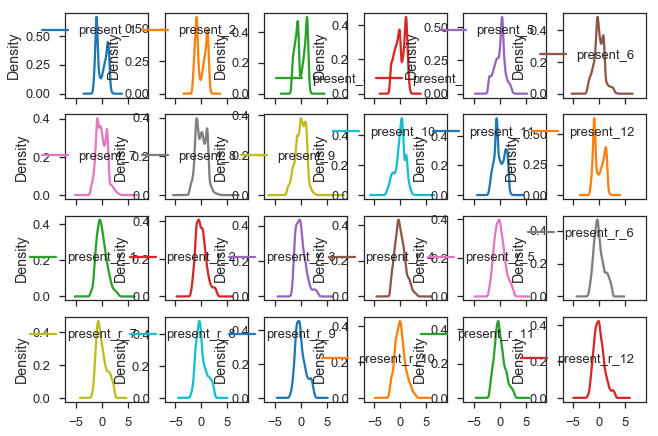

In [13]:
import seaborn as sns

_cdf = pd.DataFrame(X, columns = _clustering_df.columns)
_cdf.plot(kind='kde', subplots=True, layout=(4,6))

## Compute clusters

In [20]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 30

clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', 
                                    connectivity=conn,
                                    compute_full_tree=True)
pred = clusterer.fit_predict(X)
pred_ds = back_to_xarray(pred, 'cluster')
pred_ds['n_clusters'] = n_clusters

In [24]:
!rm "../data/fgm.clusters.test.nc"
pred_ds.to_netcdf("../data/fgm.clusters.test.nc")

Visualize as a sanity check.

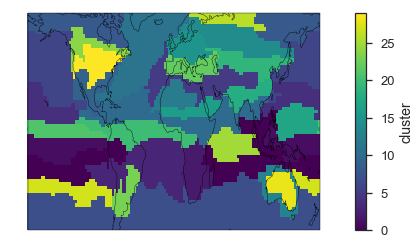

In [15]:
from darpy.plot import get_figsize
from darpy.utilities import shift_roll
import cartopy.crs as ccrs

size, aspect = 4., 1.8
figsize = get_figsize(1, 1, size, aspect)
fig, ax = plt.subplots(1, 1, figsize=figsize,
                        subplot_kw=dict(projection=ccrs.PlateCarree(),
                                        aspect='auto'))

pred_ds.cluster.plot.pcolormesh(ax=ax, infer_intervals=True, transform=ccrs.PlateCarree())
ax.coastlines()

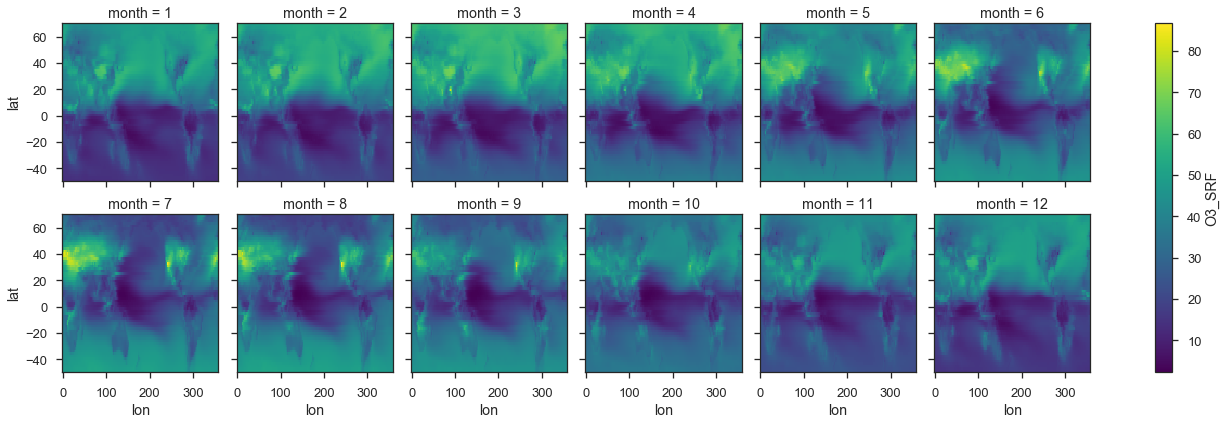

In [16]:
_monthly_cycle_data_da.plot.pcolormesh(col='month', col_wrap=6)

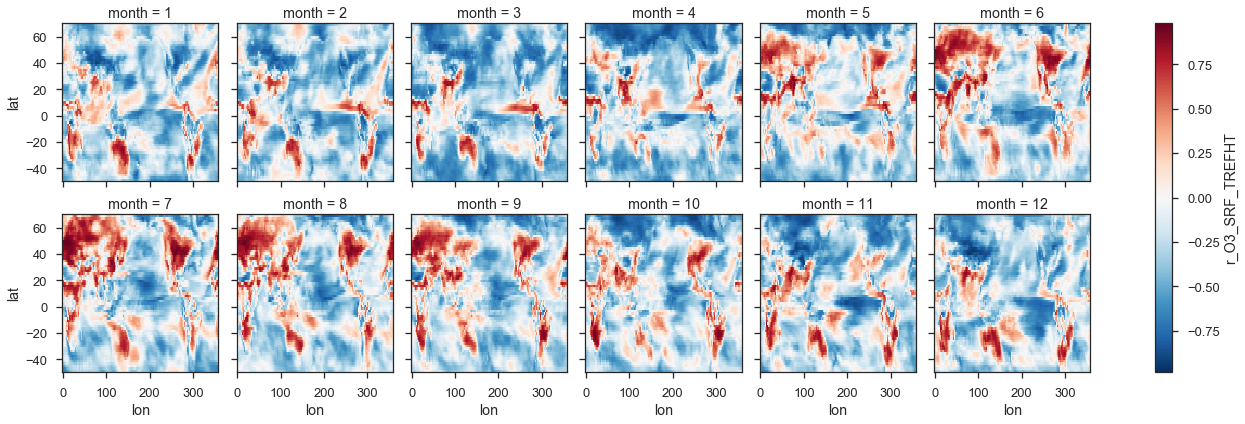

In [17]:
_monthly_regress_data_da.plot.pcolormesh(col='month', col_wrap=6)